# Случайный лес для прогнозирования цены на основе характеристик

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pickle

In [56]:
data = pd.read_csv("https://raw.githubusercontent.com/AleksKids/hedonistic-demand-from-ebay/main/Preprocessing/Great_BD.tsv", delimiter = '\t')

In [57]:
target = data[data["Is_Target"]==1]
target.reset_index(drop=True, inplace=True)
data = data[data["Is_Target"]==0]
data

,Title,Price,Shipping_cost,Sales_Count,Sales_Value,Link,Condition,Seller Notes,Brand,Model,...,OTG,Infrared,Lightning,Quad-Band,Tri-Band,Wireless charging,WAP,WCDMA,Last_Sale,Is_Target
0,Apple iPhone 11 64GB Factory Unlocked 4G LTE S...,337.59,0.00,19787.0,6679958.00,https://www.ebay.com/itm/254604777645?nordt=tr...,Very Good - Refurbished,“This iPhone 11 is in Very Good condition and ...,apple,iPhone 11,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0
1,Apple iPhone XR 64GB Factory Unlocked Smartpho...,266.28,0.00,12440.0,3312560.60,https://www.ebay.com/itm/254187678666?nordt=tr...,Very Good - Refurbished,“This Apple iPhone XR 64GB Factory Unlocked Sm...,apple,iPhone XR,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0
2,Apple iPhone 11 64GB Unlocked Smartphone - Ver...,359.11,16.93,12224.0,4389742.37,https://www.ebay.com/itm/363183815277?nordt=tr...,Very Good - Refurbished,"“This is a B+ Stock item, meaning unit is in v...",apple,Apple iPhone 11,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0
3,Apple iPhone X 64GB Factory Unlocked Phone - V...,231.98,16.50,11781.0,2732899.88,https://www.ebay.com/itm/382605209867?nordt=tr...,Very Good - Refurbished,"“This is a B+ Stock item, meaning unit is in v...",apple,Apple iPhone X,...,1.0,1,1.0,1,1,1.0,1,1,2023-06-14 00:00:00,0
4,Apple iPhone X 256GB Unlocked Smartphone - Ver...,263.59,15.34,10020.0,2641203.85,https://www.ebay.com/itm/382446518910?nordt=tr...,Very Good - Refurbished,"“This is a B+ Stock item, meaning unit is in v...",apple,Apple iPhone X,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075,Samsung Galaxy Note8 SM-N950U - 64GB (Unlocked...,128.40,0.00,37.0,4750.91,https://www.ebay.com/itm/265635248944?nordt=tr...,Used,“These devices contain a SPOT on the display. ...,samsung,Samsung Galaxy Note8,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0
3076,Brand New STALA509DCP TCL A3 32GB Storage 3GB ...,43.13,0.00,34.0,1466.36,https://www.ebay.com/itm/265731617536?nordt=tr...,New,"“This is a B+ Stock item, meaning unit is in v...",tcl,TCL A3,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0
3077,Apple iPhone 12 Pro Max - 128GB - Fully Unlock...,554.31,0.00,37.0,20509.63,https://www.ebay.com/itm/265936106963?nordt=tr...,Used,“Phones Have Been Certified By Our Industry-Le...,apple,Apple iPhone 12 Pro Max,...,0.0,0,1.0,0,0,0.0,0,0,2023-06-14 00:00:00,0
3078,Apple iPhone 13 Mini 128GB - T-Mobile / Metro ...,380.90,0.00,33.0,12569.67,https://www.ebay.com/itm/266138817726?nordt=tr...,Good - Refurbished,“LOCKED TO T-MOBILE Network - Fully tested 100...,apple,Apple iPhone 13 mini,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-14 00:00:00,0


In [58]:
target

,Title,Price,Shipping_cost,Sales_Count,Sales_Value,Link,Condition,Seller Notes,Brand,Model,...,OTG,Infrared,Lightning,Quad-Band,Tri-Band,Wireless charging,WAP,WCDMA,Last_Sale,Is_Target
0,Nokia 3.1 C (TA1141) 32GB (Cricket) Smartphone...,31.59,5.00,34.0,1074.14,https://www.ebay.com/itm/275016352540?nordt=tr...,Used,"“Refurbished to flawless new condition, 100% G...",nokia,Nokia 3.1 C,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-13,1
1,"Nokia 6 Dual SIM 5.5"" 4GB RAM 16MP Wi-Fi GPS B...",103.50,0.00,4.0,414.00,https://www.ebay.com/itm/203145222261?nordt=tr...,Open box,“The phone is in good condition. without earph...,nokia,Nokia 6,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-13,1
2,NEW Nokia 8 V 5G UW TA1257 Verizon Unlocked LT...,161.24,0.00,8.0,1289.92,https://www.ebay.com/itm/295688872962?nordt=tr...,New,"“Refurbished to flawless new condition, 100% G...",nokia,Nokia 8,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-13,1
3,Original Nokia N8 N8-00 3G WIFI GPS 12MP Touch...,42.95,5.50,26.0,1116.79,https://www.ebay.com/itm/164928279178?nordt=tr...,Used,"“1 year warranty, refurbished to a flawless ne...",nokia,Nokia N8,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-13,1
4,Nokia G50 5G | Android 11| Unlocked Smartphone...,87.00,8.22,1.0,87.00,https://www.ebay.com/itm/145123725321?nordt=tr...,Used,“Excellent Condition.”,nokia,Nokia G50,...,0.0,0,0.0,0,0,0.0,0,0,2023-06-13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,Xiaomi Redmi K60 5G Snapdragon Gen 8+ 67W Fast...,562.24,0.00,1.0,562.24,https://www.ebay.com/itm/295575470723?nordt=tr...,New,"“The item was used, and been restored to 100% ...",redmi,Redmi K60,...,0.0,1,0.0,1,1,0.0,1,1,2023-03-31,1
5356,Samsung Galaxy A20- Black (T-Mobile) (Locked) ...,299.00,0.00,1.0,299.00,https://www.ebay.com/itm/295576987139?nordt=tr...,Used,"“The item was used, and been restored to 100% ...",samsung,Samsung Galaxy A20,...,0.0,0,0.0,0,0,0.0,0,0,2023-03-27,1
5357,Xiaomi Redmi Note 11 4G Volte 128GB,180.00,9.65,1.0,180.00,https://www.ebay.com/itm/295588396316?nordt=tr...,New,"“The item was used, and been restored to 100% ...",redmi,Xiaomi Redmi Note 11,...,0.0,0,0.0,0,0,0.0,0,0,2023-04-01,1
5358,Redmi Note 8 Pro 64gb CRACKED BACK (GSM Unlock...,70.00,10.20,1.0,70.00,https://www.ebay.com/itm/295603254066?nordt=tr...,For parts or not working,"“The item was used, and been restored to 100% ...",redmi,Redmi Note 8 Pro,...,0.0,0,0.0,0,0,0.0,0,0,2023-04-28,1


## Предсказание цены по характеристикам (Гедонистическая цена)

In [16]:
y = data['Price']
X = data.drop(columns = ['Title', 'Price', 'Shipping_cost', 'Sales_Count', 'Sales_Value', 'Link', 'Seller Notes', 'Model','Lock Status', 'Contract', 'Model Number', 'Style', 'MPN', 'Connectivity', 'Features', 'Memory Card Type', 'Color'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [18]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
numeric = list(X_train.dtypes[X_train.dtypes == np.number].index)
X_train[categorical] = X_train[categorical]
X_test[categorical] = X_test[categorical]

In [19]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', RandomForestRegressor())
])

In [21]:
price_model = pipeline.fit(X_train, y_train)
y_pred = price_model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))

Test RMSE = 67.9871
Test MAE = 41.5295
Test MAPE = 0.2797


In [29]:
with open('Price Model.pkl','wb') as f:
    pickle.dump(price_model,f)

# Предсказывание объёма продаж в качестве аппроксимации общественной оценки

In [23]:
y2 = data['Sales_Value']
X2 = data.drop(columns = ['Title', 'Price', 'Shipping_cost', 'Sales_Count', 'Sales_Value', 'Link', 'Seller Notes', 'Model','Lock Status', 'Contract', 'Model Number', 'Style', 'MPN', 'Connectivity', 'Features', 'Memory Card Type', 'Color'])

In [24]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=10)

In [25]:
categorical2 = list(X_train2.dtypes[X_train2.dtypes == "object"].index)
numeric2 = list(X_train2.dtypes[X_train2.dtypes == np.number].index)
X_train2[categorical2] = X_train2[categorical2]
X_test2[categorical2] = X_test2[categorical2]

In [26]:
column_transformer2 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical2),
    ('scaling', StandardScaler(), numeric2)
])

pipeline2 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer2),
    ('regression', RandomForestRegressor())
])

In [27]:
value_model = pipeline2.fit(X_train2, y_train2)
y_pred2 = value_model.predict(X_test2)
print("Test RMSE = %.4f" % mean_squared_error(y_test2, y_pred2, squared=False))
print("Test MAE = %.4f" % mean_absolute_error(y_test2, y_pred2))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test2, y_pred2))

Test RMSE = 247673.0379
Test MAE = 64858.0561
Test MAPE = 2.2797


In [28]:
with open('Sales Value Model.pkl','wb') as f:
    pickle.dump(value_model,f)

______

# Используем модель

In [59]:
target_features = target.drop(columns = ['Title', 'Price', 'Shipping_cost', 'Sales_Count', 'Sales_Value', 'Link', 'Seller Notes', 'Model','Lock Status', 'Contract', 'Model Number', 'Style', 'MPN', 'Connectivity', 'Features', 'Memory Card Type', 'Color'])
target["Expected Price"] = price_model.predict(target_features)
target["Expected Sales Value"] = value_model.predict(target_features)

In [60]:
target

,Title,Price,Shipping_cost,Sales_Count,Sales_Value,Link,Condition,Seller Notes,Brand,Model,...,Lightning,Quad-Band,Tri-Band,Wireless charging,WAP,WCDMA,Last_Sale,Is_Target,Expected Price,Expected Sales Value
0,Nokia 3.1 C (TA1141) 32GB (Cricket) Smartphone...,31.59,5.00,34.0,1074.14,https://www.ebay.com/itm/275016352540?nordt=tr...,Used,"“Refurbished to flawless new condition, 100% G...",nokia,Nokia 3.1 C,...,0.0,0,0,0.0,0,0,2023-06-13,1,52.511317,3561.987228
1,"Nokia 6 Dual SIM 5.5"" 4GB RAM 16MP Wi-Fi GPS B...",103.50,0.00,4.0,414.00,https://www.ebay.com/itm/203145222261?nordt=tr...,Open box,“The phone is in good condition. without earph...,nokia,Nokia 6,...,0.0,0,0,0.0,0,0,2023-06-13,1,140.192405,16027.996287
2,NEW Nokia 8 V 5G UW TA1257 Verizon Unlocked LT...,161.24,0.00,8.0,1289.92,https://www.ebay.com/itm/295688872962?nordt=tr...,New,"“Refurbished to flawless new condition, 100% G...",nokia,Nokia 8,...,0.0,0,0,0.0,0,0,2023-06-13,1,214.434865,21250.634683
3,Original Nokia N8 N8-00 3G WIFI GPS 12MP Touch...,42.95,5.50,26.0,1116.79,https://www.ebay.com/itm/164928279178?nordt=tr...,Used,"“1 year warranty, refurbished to a flawless ne...",nokia,Nokia N8,...,0.0,0,0,0.0,0,0,2023-06-13,1,83.514717,6023.795900
4,Nokia G50 5G | Android 11| Unlocked Smartphone...,87.00,8.22,1.0,87.00,https://www.ebay.com/itm/145123725321?nordt=tr...,Used,“Excellent Condition.”,nokia,Nokia G50,...,0.0,0,0,0.0,0,0,2023-06-13,1,207.509225,15650.502392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,Xiaomi Redmi K60 5G Snapdragon Gen 8+ 67W Fast...,562.24,0.00,1.0,562.24,https://www.ebay.com/itm/295575470723?nordt=tr...,New,"“The item was used, and been restored to 100% ...",redmi,Redmi K60,...,0.0,1,1,0.0,1,1,2023-03-31,1,298.962633,31350.084767
5356,Samsung Galaxy A20- Black (T-Mobile) (Locked) ...,299.00,0.00,1.0,299.00,https://www.ebay.com/itm/295576987139?nordt=tr...,Used,"“The item was used, and been restored to 100% ...",samsung,Samsung Galaxy A20,...,0.0,0,0,0.0,0,0,2023-03-27,1,72.097467,6728.049942
5357,Xiaomi Redmi Note 11 4G Volte 128GB,180.00,9.65,1.0,180.00,https://www.ebay.com/itm/295588396316?nordt=tr...,New,"“The item was used, and been restored to 100% ...",redmi,Xiaomi Redmi Note 11,...,0.0,0,0,0.0,0,0,2023-04-01,1,264.346545,33149.755545
5358,Redmi Note 8 Pro 64gb CRACKED BACK (GSM Unlock...,70.00,10.20,1.0,70.00,https://www.ebay.com/itm/295603254066?nordt=tr...,For parts or not working,"“The item was used, and been restored to 100% ...",redmi,Redmi Note 8 Pro,...,0.0,0,0,0.0,0,0,2023-04-28,1,158.853591,24413.403077


In [64]:
target .to_csv('Nokia and Redmi estimated.tsv', index = False, sep = '\t')

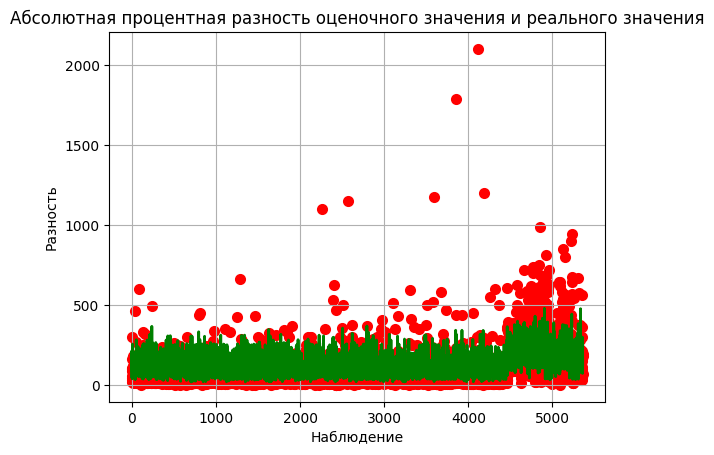

In [63]:
fig, ax = plt.subplots(1)
ax.scatter(target.index, target["Price"], lw=2, c="r")
ax.plot(target.index, target["Expected Price"], lw=2, c="g")
ax.set_title(r'Абсолютная процентная разность оценочного значения и реального значения')
ax.set_xlabel('Наблюдение')
ax.set_ylabel('Разность')
ax.grid()

Есть выбросы. Клятые капиталисты завышают цены и народ ведётся.